In [75]:
import cv2
import time
import glob
import itertools
import collections
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

%matplotlib inline

In [76]:
# Read in our vehicles and non-vehicles
car = glob.glob("./vehicles/*/*.png")
noncar = glob.glob("./non-vehicles/*/*.png")

In [77]:
print("Number of cars:", len(car))
print("Number of non-cars:", len(noncar))

Number of cars: 8792
Number of non-cars: 8968


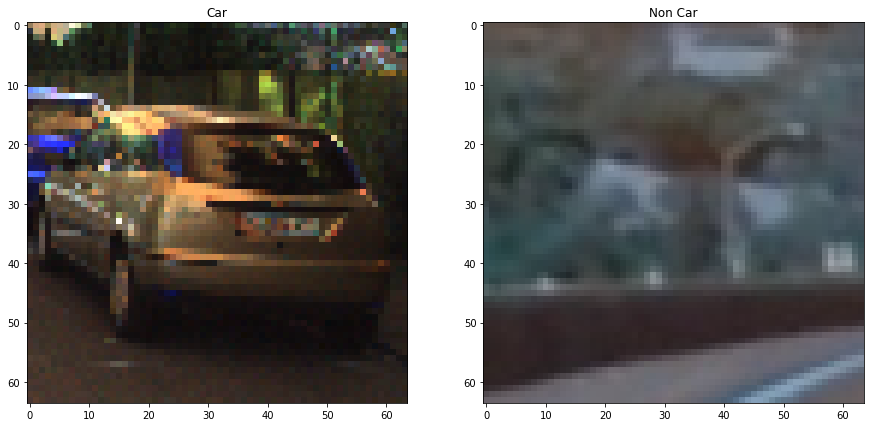

In [78]:
# Show random images
idx_car = np.random.randint(0, len(car))
idx_noncar = np.random.randint(0, len(noncar))

# Plot the images
fig = plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.imshow(cv2.imread(car[idx_car]))
plt.title('Car')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(noncar[idx_noncar]))
plt.title('Non Car')
plt.savefig('saved_images/random_images.png')

## Function to return HOG features

In [79]:
# From  Udacity lessons
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis is True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

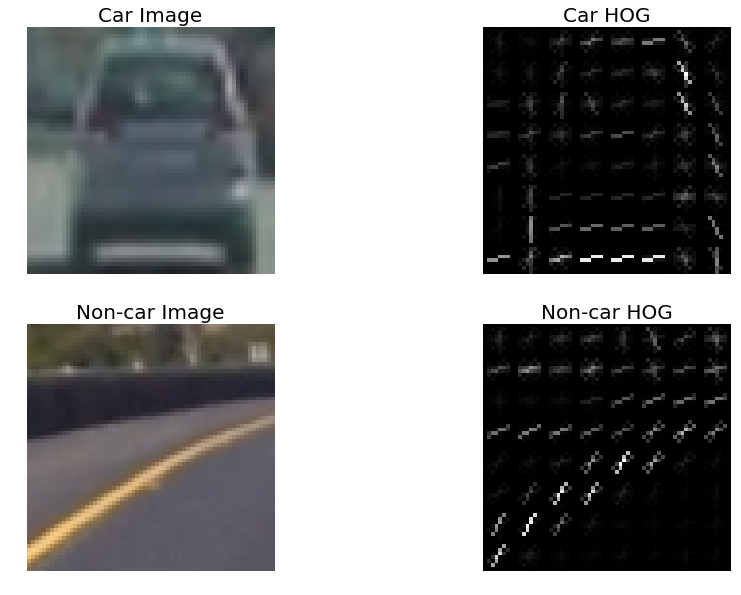

In [80]:
car_img = mpimg.imread(car[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
fig = plt.subplots(2, 2, figsize=(15,10))
plt.subplot(221)
plt.imshow(car_img)
plt.title('Car Image', fontsize=20)
plt.axis('off');
plt.subplot(222)
plt.imshow(car_dst, cmap='gray')
plt.title('Car HOG', fontsize=20)
plt.axis('off');
plt.subplot(223)
plt.imshow(noncar_img)
plt.title('Non-car Image', fontsize=20)
plt.axis('off');
plt.subplot(224)
plt.imshow(noncar_dst, cmap='gray')
plt.title('Non-car HOG', fontsize=20)
plt.axis('off');
plt.savefig('saved_images/car_hog.png')

## Function to compute Spatial Binning

In [81]:
# From  Udacity lessons
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

## Function to compute color histogram features

In [82]:
# From  Udacity lessons
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Convert colors

In [83]:
convert_color = {'HSV': cv2.COLOR_RGB2HSV, 'LUV': cv2.COLOR_RGB2LUV, 'HLS': cv2.COLOR_RGB2HLS, 'YUV': cv2.COLOR_RGB2YUV, 'YCrCb': cv2.COLOR_RGB2YCrCb}

## Extract Features

In [84]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = np.copy(image) if color_space == 'RGB' \
                        else cv2.cvtColor(image, convert_color[color_space])
        file_features = []
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat:
        # Call get_hog_features() with vis=False, feature_vec=True
            assert hog_channel in (0, 1, 2, "ALL")
            if hog_channel == 'ALL':
                hog_features = np.ravel([get_hog_features(feature_image[:,:, channel], 
                                        orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                                        for channel in range(feature_image.shape[2])])     
            else:
                hog_features = get_hog_features(feature_image[:,:, hog_channel],
                                                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        #We now concatenate spatial_features | hist_features | hog_features
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features

## SVC training

In [85]:
# Read in our vehicles and non-vehicles
car = glob.glob("./vehicles/*/*.png")
noncar = glob.glob("./non-vehicles/*/*.png")

SAMPLE_SIZE = 100000

cars = car[0:SAMPLE_SIZE]
noncar = noncar[0:SAMPLE_SIZE]

print("Number of cars:", len(car))
print("Number of non-cars:", len(noncar))

Number of cars: 8792
Number of non-cars: 8968


In [86]:
### TODO: Test diffrent parameters to see results.
color_space = "LUV" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

#Do not change
spatial_feat = True  # Spatial features
hist_feat = True     # Histogram features
hog_feat = True      # HOG features


t0 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(noncar, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Extracted features in {:.2f} seconds".format(time.time() - t0))

Extracted features in 115.85 seconds


In [87]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
RAND_STATE = 42 #np.random.randint(0, 100)
#RAND_STATE = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=20, random_state=RAND_STATE)
print("Training on {} elts.\n".format(len(X_train)))

print("Using:", orient,"orientations", pix_per_cell, "pixels per cell and", cell_per_block,"cells per block")
print("Feature vector length:", len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t0 = time.time()
svc.fit(X_train, y_train)
print("Time to train SVC: {:.2f} sec".format(time.time() - t0))

# Check the score of the SVC
print("Accuracy of SVC: {:.4f}".format(svc.score(X_test, y_test)))

Training on 17740 elts.

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284
Time to train SVC: 35.54 sec
Accuracy of SVC: 1.0000


## Sliding window

In [88]:
# From  Udacity lessons
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, hog_channel, ystart, ystop, scale, svc, scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, set_point=-1e6):
    
    assert hog_channel in (0,"ALL")

    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, convert_color[color_space])
    
    if scale != 1:
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(ctrans_tosearch.shape[1]/scale), np.int(ctrans_tosearch.shape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    box_list = []
    for xb, yb in itertools.product(range(nxsteps), range(nysteps)):
        xpos = xb * cells_per_step
        ypos = yb * cells_per_step

        # Extract HOG for this patch
        hog_feat1 = hog1[ypos : ypos+nblocks_per_window, xpos : xpos+nblocks_per_window].ravel() 
        hog_feat2 = hog2[ypos : ypos+nblocks_per_window, xpos : xpos+nblocks_per_window].ravel() 
        hog_feat3 = hog3[ypos : ypos+nblocks_per_window, xpos : xpos+nblocks_per_window].ravel()             
        if hog_channel == "ALL":
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        elif hog_channel == 0:
            hog_features = hog_feat1
        else:
            raise RuntimeError 

        # Extract the image patch
        xleft = xpos * pix_per_cell
        ytop = ypos * pix_per_cell
        subimg = cv2.resize(ctrans_tosearch[ytop : ytop+window, xleft : xleft+window], (64,64))

        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)
        # Scale features and make a prediction
        test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        

        test_prediction = svc.predict(test_features).squeeze()
        #print('test_prediction', test_prediction[0])
        conf = svc.decision_function(test_features).squeeze()
        #print('debug2: decision_function {} | '.format(conf))
        
        #We draw boxes around positive predictions
        #see https://discussions.udacity.com/t/detection-fails-when-white-car-is-far-00-25-to-00-31/380480/6
        if test_prediction == 1 and conf > set_point:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            box_list.append( ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) )
                   
    return box_list


def draw_boxes(img, box_list):
    
    draw_img = np.copy(img)
    for box in box_list:
        cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)
    return draw_img

## Test

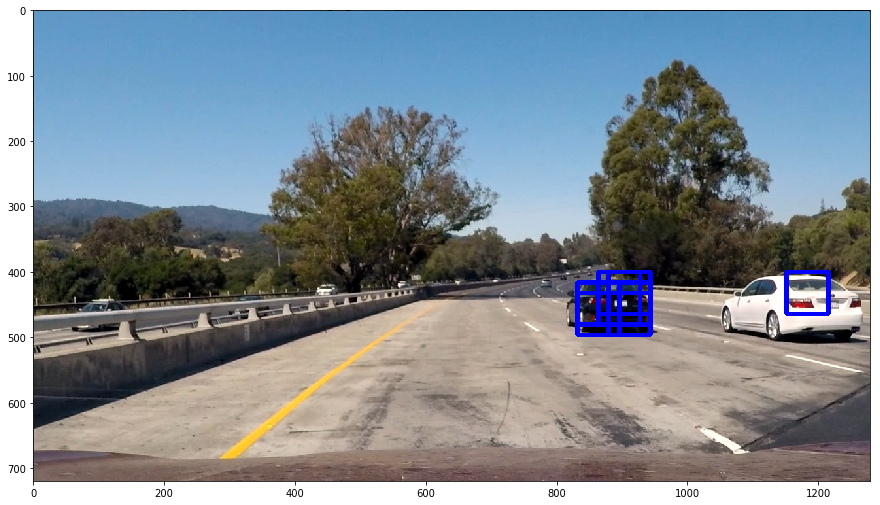

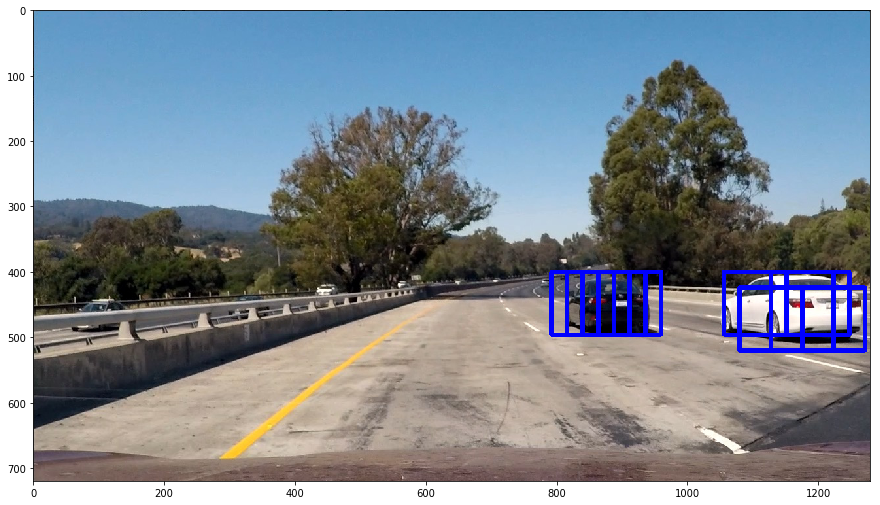

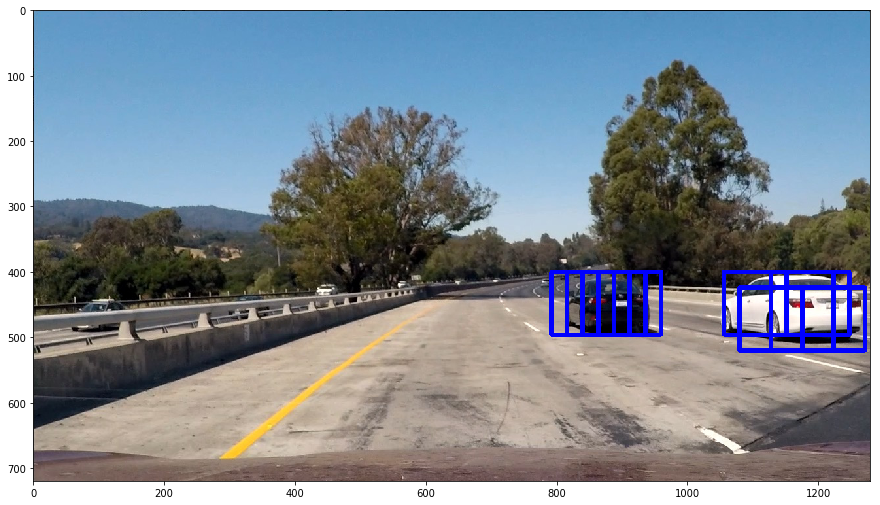

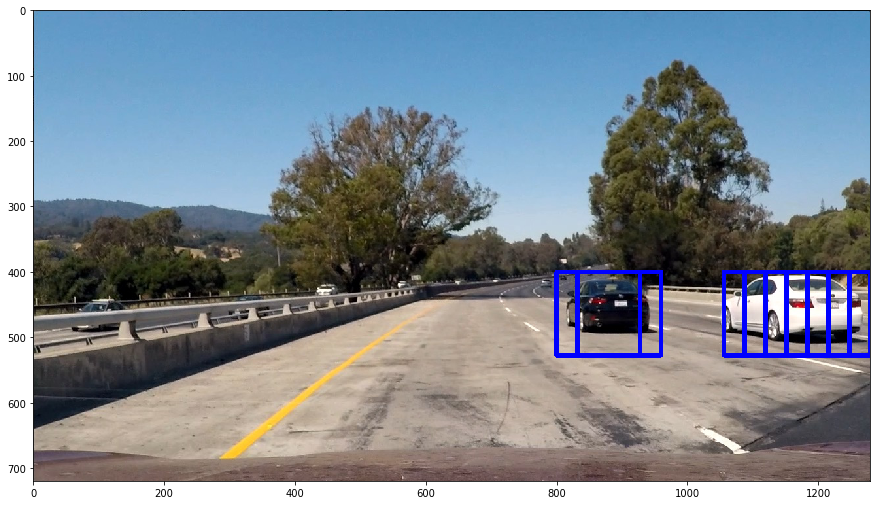

In [89]:
#img = mpimg.imread('./test_images/bbox-example-image.jpg')
img = mpimg.imread('./test_images/test1.jpg')


ystart = 400
ystop = 656
scales = [1,1.5,1.5, 2.0]

for scale in scales:
    box_list = find_cars(img, color_space, hog_channel, ystart, ystop, scale, svc, X_scaler, orient, \
                    pix_per_cell, cell_per_block, spatial_size, hist_bins, set_point=.2)

    out_img = draw_boxes(img, box_list)

    plt.figure(figsize=(15,10))
    plt.imshow(out_img)
    plt.savefig('saved_images/find_cars.jpg')

## Heat map

In [90]:
# From Udacity lessons
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

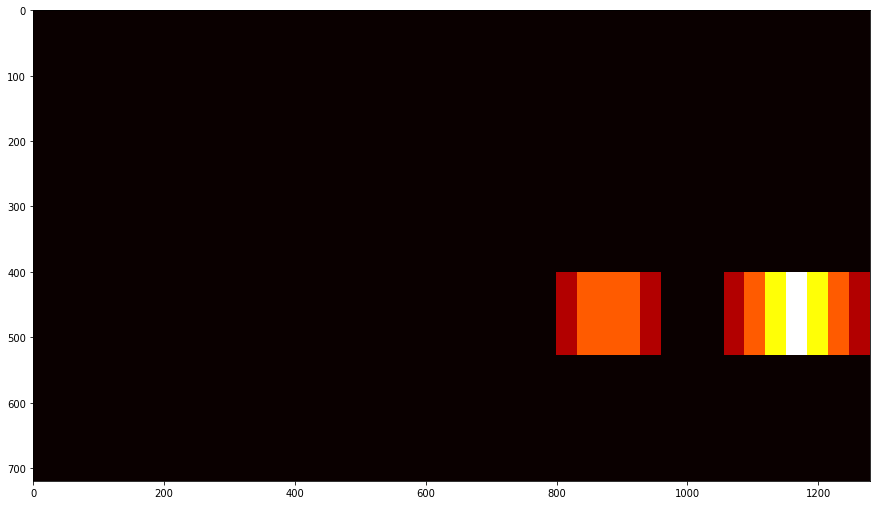

In [91]:
# Test out heatmap
test_img = img
heat = np.zeros_like(test_img[:,:,0])
heat = add_heat(heat, box_list)
plt.figure(figsize=(15,10))
plt.imshow(heat, cmap='hot')
plt.savefig('saved_images/heatmap.jpg')

## Apply threshold to heat-map

In [92]:
# From Udacity lessons
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

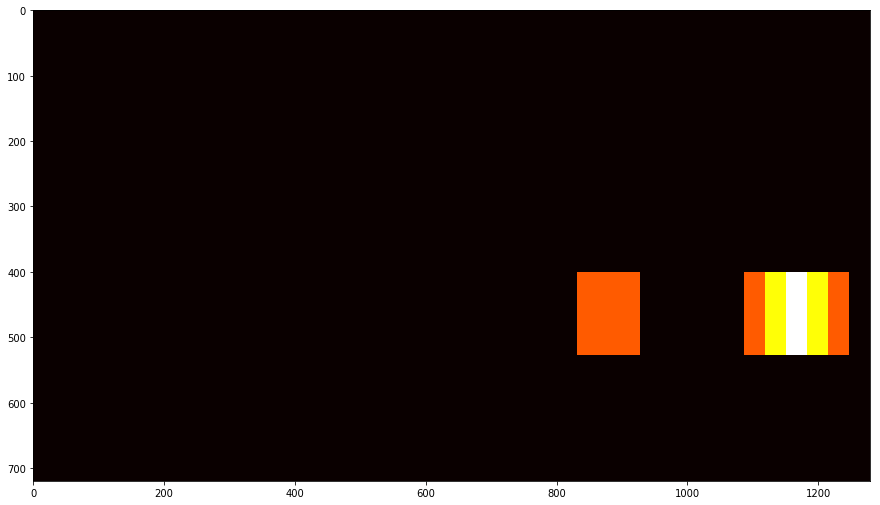

In [93]:
# Test out threshold
thresh = apply_threshold(heat, 1)
plt.figure(figsize=(15,10))
plt.imshow(thresh, cmap='hot')
plt.savefig('saved_images/threshold_heatmap.jpg')

## Threshold heatmap to remove false positives

2 cars found


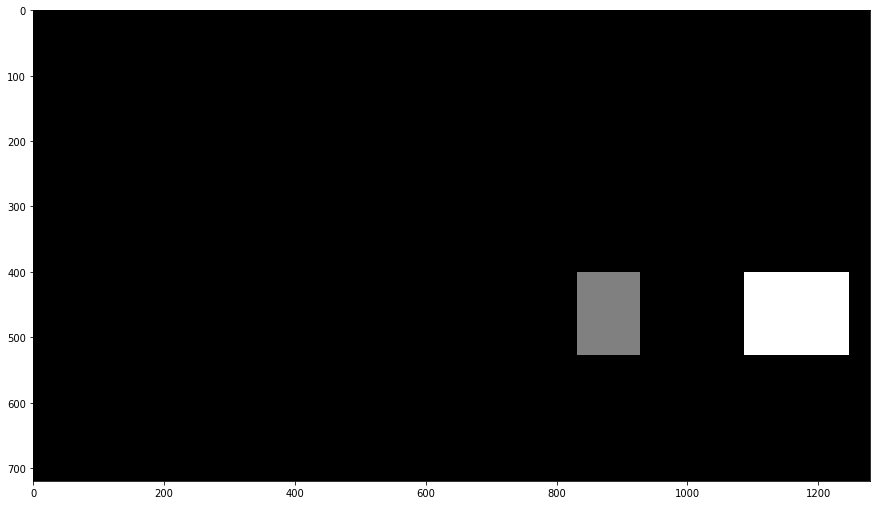

In [94]:
labels = label(heat)
plt.figure(figsize=(15,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')
plt.savefig('saved_images/remove_false_positives.jpg')

## Draw boxes

In [95]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

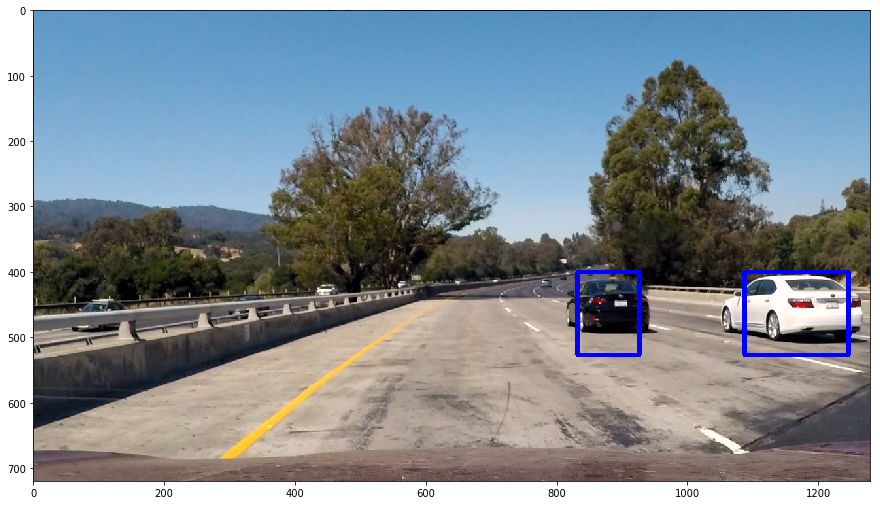

In [96]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)

# Display the image
plt.figure(figsize=(15,10))
plt.imshow(draw_img)
plt.savefig('saved_images/draw_boxes.jpg')

## Pipeline

In [97]:
class VehicleTracker(object):
    
    def __init__(self, cache=8, heat_threshold=3, set_point=.2):
        
        self.cache = cache #nb of images in cache
        self.scales = (1, 1.25, 1.5, 1.8)
        self.recent_boxes = collections.deque(maxlen=self.cache*len(self.scales))
        self.heat_threshold = heat_threshold
        #print("Init with a deque of len", self.recent_boxes.maxlen)
        self.set_point = set_point
    
    def process(self, image):
        ystart, ystop = 400, 656

        for scale in self.scales:
            current_box_list = find_cars(image, color_space, hog_channel, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, set_point=self.set_point)
            self.recent_boxes.append(current_box_list)
        
        heat = np.zeros_like(image[:,:,0], dtype='float64')
        # Add heat to each box in box list
        #for box_list in self.recent_boxes:
        #    heat = add_heat(heat, box_list)
        it = itertools.chain.from_iterable(self.recent_boxes)
        heat = add_heat(heat, it)
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.heat_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        
        return draw_img

In [98]:
%%time
%%capture

vehicle_tracker = VehicleTracker(cache=16, heat_threshold=9, set_point=-1.5)

#Create video
input_file = "test_video.mp4"
output_file = "test_output_video4.mp4"

input_video = VideoFileClip(input_file)

t0 = time.time()
output_video = input_video.fl_image(vehicle_tracker.process)
output_video.write_videofile(output_file, audio=False)

 97%|█████████▋| 38/39 [01:33<00:02,  2.87s/it]


CPU times: user 1min 32s, sys: 3.06 s, total: 1min 35s
Wall time: 1min 37s


In [39]:
%%time
%%capture

vehicle_tracker = VehicleTracker(cache=16, heat_threshold=9, set_point=-1.5)

#Create video
input_file = "project_video.mp4"
output_file = "project_video_output.mp4"

input_video = VideoFileClip(input_file)

t0 = time.time()
output_video = input_video.fl_image(vehicle_tracker.process)
output_video.write_videofile(output_file, audio=False)

100%|█████████▉| 1260/1261 [51:09<00:02,  2.37s/it]  


CPU times: user 47min 42s, sys: 1min 29s, total: 49min 12s
Wall time: 51min 13s
